In [1]:
from curves import volatility
import numpy as np
import matplotlib.pyplot as plt

### Plot instantaneous volatility at t and tau
Note that instantanous volatility at tau is the integral over the instantanous curve from T to tau.

0.05372754469670032

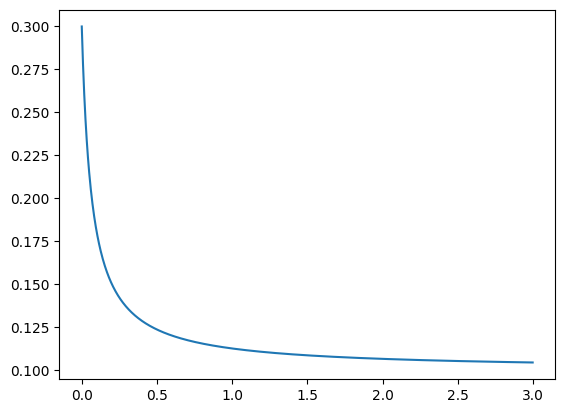

In [2]:

t = 0
T = 3
tau =1/12
dt = 1/365
#n_steps = int(T / dt)

b = 2/3/10
a = 0.2*b
c = 0.1

times_tau = np.arange(tau, T, dt) 
times_t = np.arange(t, T, dt) 

vol_tau = volatility.sigma_brs(t, tau, times_tau, a,b,c)

vol_inst = volatility.sigma_instantanous(t, times_t, a, b, c)


plt.plot(times_t, vol_inst)
#plt.plot(times_tau, vol_tau)
#plt.plot(times_tau, plugin_T1equalT2)

# Integral of variance instantanous equal to vol_tau.
np.sqrt(sum(vol_inst[0:7]**2)/7)
vol_tau[0]**2 # vol = 0.2760, var = 0.07618969



## Test plugin-volatility

In [8]:
b = 2/3/10
a = 0.2*b
c = 0.1

t = 0
T1 = 0.1
T2 = 0.100001
tau = 0.000001


s =t

volatility.sigma_plugin(t,tau, T1, T2, a, b,c)
#plt.plot(times_tau, ve)


0.21386301306488406

### Test consistency between total volatility and factors

In [4]:

t = 0
T = 1 
tau =1/12

a= 0.9
b = 0.6
c= 0.1
    
vol = volatility.sigma_brs(t, tau, T, a,b,c)

print("volatility:"+ str(vol))
print("Variance:"+ str(vol**2))

f1 = volatility.sigma_factor1(t, tau, T, a,b)
f2 = volatility.sigma_factor2(t, tau, T, a,b,c)
f3 = volatility.sigma_factor3(t, tau, T, c)

print("SumVariance:"+ str((f1**2+f2**2+f3**2)))

volatility:0.6777365035803672
Variance:0.4593267682853411
SumVariance:0.45932676828534064


## Simulation

### One factor

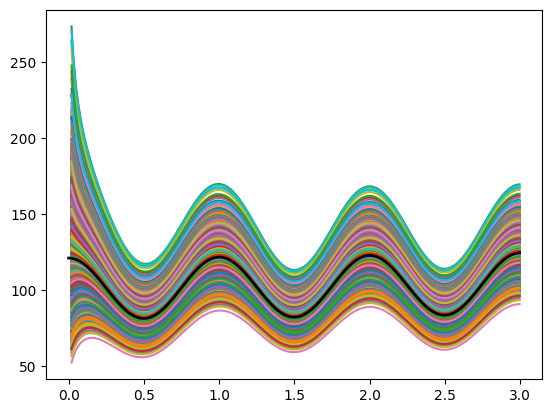

In [5]:
# Parameters 

n_sims = 1000  # Number of paths to simulate
T = 3  # Total time in years
dt = 1/365  # Daily time step
#n_steps = int(T / dt)
tau = 7/365


b = 2/3/10
a = 0.2*b
c = 0.1

times = np.arange(0, T, dt)   # Time steps
times_tau = np.arange(tau, T, dt) 

# Generate independent random samples
w = np.random.randn(n_sims, 1)

term_structure_initial = volatility.term_structure(times)
term_structure_tau = volatility.term_structure(times_tau)

#sigma = 0.3
vol_tau = volatility.sigma_brs(t, tau, times_tau, a,b,c)

z = np.exp(vol_tau * w - 0.5 * vol_tau**2*tau) 

sim_curves = z *  term_structure_tau

# Plot each row as a separate line
for i, row in enumerate(sim_curves):
    plt.plot(times_tau,row, label=f'Row {i+1}')
    
plt.plot(times,term_structure_initial, color='black', lw=2, label='Term Structure')
#plt.plot(times,sigma_brs(t, t+dt, taus, a,b,c), color='black', lw=2, label='Term Structure')



## Check simulation consistency
Note that it needs 10000 simulation to fit volatility accurately

0.13848495294356286

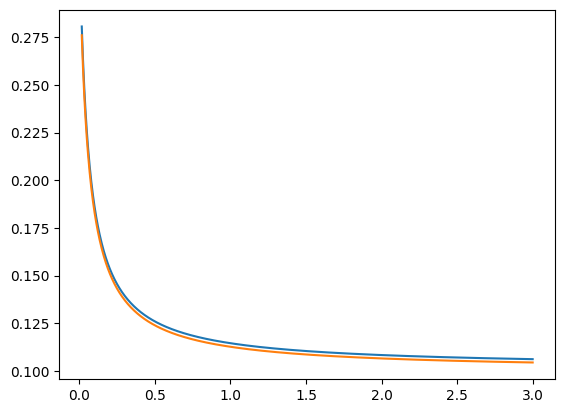

In [6]:
returns = np.log(z)
std_return = np.std(returns, axis = 0) 



plt.plot(times_tau, std_return)
plt.plot(times_tau, vol_tau)
np.sqrt(tau)